# 911 Calls Project

## Overview

### Understanding the Background

* Montgomery County

Montgomery County, locally also referred to as Montco, is a county located in the Commonwealth of Pennsylvania. As of the 2010 census, the population was 799,874, making it the third-most populous county in Pennsylvania, after Philadelphia and Allegheny Counties. The county seat is Norristown. Montgomery County is very diverse, ranging from farms and open land in Upper Hanover to densely populated rowhouse streets in Cheltenham.

* 911 Calls

Created by Congress in 2004 as the 911 Implementation and Coordination Office (ICO), the National 911 Program is housed within the National Highway Traffic Safety Administration at the U.S. Department of Transportation and is a joint program with the National Telecommunication and Information Administration in the Department of Commerce.

### Goal:

* Locations from which 911 calls are most frequent
* Time daily, month, weekly patterns of 911 calls
* Major Causes of 911 calls


**This analysis will help to deploy more agents in specific location and save/help people at right time**

---
----

### The Data

`Acknowledgements`: Data provided by  <a href='http://www.pieriandata.com'>montcoalert.org</a>

we will be analyzing some 911 call data from [Kaggle](https://www.kaggle.com/mchirico/montcoalert). The data contains the following fields:

Column | Definition
--- | -----------
lat | Latitude
lng | Longitude
desc | Description of the Emergency Call
zip | Zipcode
title | Title of Emergency
timeStamp | YYYY-MM-DD HH:MM:SS
twp | Township
addr | Address
e | Dummy variable (always 1)



### Data Import and first Inspection

##### 911.csv

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
sns.set()

**Read in the csv file as a dataframe called df**

In [2]:
df = pd.read_csv('911.csv')

**Check the head of df**

In [4]:
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


**Check the info() of the df**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


**Check the null values**

In [6]:
df.isnull().sum()

lat              0
lng              0
desc             0
zip          80199
title            0
timeStamp        0
twp            293
addr             0
e                0
dtype: int64

### Handling duplicated and missing values

In [7]:
display(df.duplicated().sum())
df.drop_duplicates(inplace = True , ignore_index=True)
df.reset_index(drop = True, inplace = True)

240

In [8]:
df.isnull().sum()

lat              0
lng              0
desc             0
zip          80165
title            0
timeStamp        0
twp            293
addr             0
e                0
dtype: int64

In [9]:
missing_percentage = ((df.isnull().sum() / len(df)) * 100).round(3).astype(str)+'%'
missing_percentage

lat             0.0%
lng             0.0%
desc            0.0%
zip          12.086%
title           0.0%
timeStamp       0.0%
twp           0.044%
addr            0.0%
e               0.0%
dtype: object

**Remove rows with missing values in the `twp` column**

In [10]:
df = df.dropna(subset=['twp'])

In [11]:
((df.isnull().sum() / len(df)) * 100).round(3).astype(str)+'%'

lat             0.0%
lng             0.0%
desc            0.0%
zip          12.066%
title           0.0%
timeStamp       0.0%
twp             0.0%
addr            0.0%
e               0.0%
dtype: object

**I don't think we should drop the rows with null values in the `zip` column**

* Lets try getting the unique `twp` and its corresponding `zip` then try to use it filling the null zip code if the twp matches

In [12]:
# Get unique township values from the 'twp' column
unique_townships = df['twp'].unique()

# Create a dictionary mapping township to zip code
township_to_zip_mapping = {twp: None for twp in unique_townships}

# Fill the dictionary with zip codes
for twp in unique_townships:
    zip_code = None  # Initialize zip_code as None
    rows_with_twp = df[df['twp'] == twp]  # Filter rows with the same twp

    for index, row in rows_with_twp.iterrows():
        if pd.notna(row['zip']):  # Check if zip is not NaN
            zip_code = row['zip']
            break  # Stop searching once a non-null zip is found

    township_to_zip_mapping[twp] = zip_code

In [13]:
# Fill missing zip codes based on township
df['zip'] = df.apply(lambda row: township_to_zip_mapping.get(row['twp'], row['zip']), axis=1)

In [14]:
((df.isnull().sum() / len(df)) * 100).round(3).astype(str)+'%'

lat          0.0%
lng          0.0%
desc         0.0%
zip          0.0%
title        0.0%
timeStamp    0.0%
twp          0.0%
addr         0.0%
e            0.0%
dtype: object

* Replacing null values with a placeholder

In [16]:
# df['zip'] = df['zip'].fillna(-1)

**We can drop the `e` column and covert the `zip` column from float to integers and it will make more sense**

In [15]:
df = df.drop(columns=['e'])
df['zip'] = df['zip'].astype(int).astype(str)

**These timestamps are still strings. We need to convert the column from strings to DateTime objects.**

In [16]:
display(type(df['timeStamp'].iloc[0]))
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
display(type(df['timeStamp'].iloc[0]))

str

pandas._libs.tslibs.timestamps.Timestamp

### Data preprocessing and feature engineering

In [17]:
df['title'].nunique()

148

**In the titles column there are "Reasons/Departments"**

In [18]:
df['title']

0              EMS: BACK PAINS/INJURY
1             EMS: DIABETIC EMERGENCY
2                 Fire: GAS-ODOR/LEAK
3              EMS: CARDIAC EMERGENCY
4                      EMS: DIZZINESS
                     ...             
663277    Traffic: VEHICLE ACCIDENT -
663278          EMS: GENERAL WEAKNESS
663279          EMS: VEHICLE ACCIDENT
663280            Fire: BUILDING FIRE
663281    Traffic: VEHICLE ACCIDENT -
Name: title, Length: 662989, dtype: object

In [19]:
df['Department'] = df['title'].apply(lambda title: title.split(':')[0])
df['Reason'] = df['title'].apply(lambda title: title.split(':')[1])

**We can now grab specific attributes from a Datetime object by calling them.**

In [20]:
df['Hour'] = df['timeStamp'].apply(lambda time: time.hour)
df['Day'] = df['timeStamp'].dt.day
df['nDay_of_Week'] = df['timeStamp'].apply(lambda time: time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day_of_Week'] = df['nDay_of_Week'].map(dmap)
df['Month'] = df['timeStamp'].apply(lambda time: time.month)
df['Year'] = df['timeStamp'].apply(lambda time: time.year)

In [24]:
# raise Exception("Execution stopped by user")
# pd.DataFrame(df.iloc[0]).T  # Transpose to convert Series to DataFrame

In [21]:
df

,lat,lng,desc,zip,title,timeStamp,twp,addr,Department,Reason,Hour,Day,nDay_of_Week,Day_of_Week,Month,Year
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,EMS,BACK PAINS/INJURY,17,10,3,Thu,12,2015
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,EMS,DIABETIC EMERGENCY,17,10,3,Thu,12,2015
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,Fire,GAS-ODOR/LEAK,14,10,3,Thu,12,2015
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,EMS,CARDIAC EMERGENCY,16,10,3,Thu,12,2015
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,19464,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,EMS,DIZZINESS,16,10,3,Thu,12,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663277,40.157956,-75.348060,SUNSET AVE & WOODLAND AVE; EAST NORRITON; 2020...,19403,Traffic: VEHICLE ACCIDENT -,2020-07-29 15:46:51,EAST NORRITON,SUNSET AVE & WOODLAND AVE,Traffic,VEHICLE ACCIDENT -,15,29,2,Wed,7,2020
663278,40.136306,-75.428697,EAGLEVILLE RD & BUNTING CIR; LOWER PROVIDENCE...,19403,EMS: GENERAL WEAKNESS,2020-07-29 15:52:19,LOWER PROVIDENCE,EAGLEVILLE RD & BUNTING CIR,EMS,GENERAL WEAKNESS,15,29,2,Wed,7,2020
663279,40.013779,-75.300835,HAVERFORD STATION RD; LOWER MERION; Station 3...,19010,EMS: VEHICLE ACCIDENT,2020-07-29 15:52:52,LOWER MERION,HAVERFORD STATION RD,EMS,VEHICLE ACCIDENT,15,29,2,Wed,7,2020
663280,40.121603,-75.351437,MARSHALL ST & HAWS AVE; NORRISTOWN; 2020-07-29...,19401,Fire: BUILDING FIRE,2020-07-29 15:54:08,NORRISTOWN,MARSHALL ST & HAWS AVE,Fire,BUILDING FIRE,15,29,2,Wed,7,2020


### Exploratory Data Analysis
#### Basic Questions

In [22]:
numerical_columns = ['lat', 'lng', 'Hour', 'Day', 'nDay_of_Week', 'Month', 'Year']
numerical_summary = df[numerical_columns].describe()
numerical_summary

,lat,lng,Hour,Day,nDay_of_Week,Month,Year
count,662989.000000,662989.000000,662989.000000,662989.000000,662989.000000,662989.000000,662989.000000
mean,40.158147,-75.300035,13.044411,15.650175,2.899891,6.334812,2017.765796
std,0.220673,1.673350,5.651348,8.772939,1.950565,3.475280,1.335122
min,0.000000,-119.698206,0.000000,1.000000,0.000000,1.000000,2015.000000
25%,40.100344,-75.392772,9.000000,8.000000,1.000000,3.000000,2017.000000
50%,40.143869,-75.305143,13.000000,16.000000,3.000000,6.000000,2018.000000
75%,40.229008,-75.211812,17.000000,23.000000,5.000000,9.000000,2019.000000
max,51.335390,87.854975,23.000000,31.000000,6.000000,12.000000,2020.000000


In [23]:
# Categorical columns in the DataFrame
categorical_columns = ['title', 'twp', 'Department', 'Reason', 'Day_of_Week']

# Calculate class balance for each categorical column
for column in categorical_columns:
    class_balance = df[column].value_counts(normalize=True).head(7)
    print(f"Class balance for column '{column}':\n{class_balance}\n")

Class balance for column 'title':
Traffic: VEHICLE ACCIDENT -    0.223705
Traffic: DISABLED VEHICLE -    0.072229
Fire: FIRE ALARM               0.057787
EMS: FALL VICTIM               0.052271
EMS: RESPIRATORY EMERGENCY     0.051624
EMS: CARDIAC EMERGENCY         0.048735
EMS: VEHICLE ACCIDENT          0.038396
Name: title, dtype: float64

Class balance for column 'twp':
LOWER MERION      0.083667
ABINGTON          0.060223
NORRISTOWN        0.056737
UPPER MERION      0.054284
CHELTENHAM        0.046085
POTTSTOWN         0.041301
UPPER MORELAND    0.034581
Name: twp, dtype: float64

Class balance for column 'Department':
EMS        0.501334
Traffic    0.347081
Fire       0.151585
Name: Department, dtype: float64

Class balance for column 'Reason':
 VEHICLE ACCIDENT -       0.223705
 DISABLED VEHICLE -       0.072229
 FIRE ALARM               0.057962
 VEHICLE ACCIDENT         0.054717
 FALL VICTIM              0.052281
 RESPIRATORY EMERGENCY    0.051627
 CARDIAC EMERGENCY        0.048

In [24]:
from tabulate import tabulate

# Categorical columns in the DataFrame
categorical_columns = ['title', 'twp', 'Department', 'Reason', 'Day_of_Week']

# Create a list to store class balance results as tables
class_balance_tables = []

# Calculate class balance for each categorical column
for column in categorical_columns:
    class_balance = df[column].value_counts(normalize=True).head(7)
    table = tabulate(class_balance.reset_index(), headers=[column, 'Class Balance'], tablefmt='grid')
    class_balance_tables.append(table)

# Print class balance tables
for table in class_balance_tables:
    print(table)
    print("\n")


+----+-----------------------------+-----------------+
|    | title                       |   Class Balance |
+====+=============================+=================+
|  0 | Traffic: VEHICLE ACCIDENT - |       0.223705  |
+----+-----------------------------+-----------------+
|  1 | Traffic: DISABLED VEHICLE - |       0.072229  |
+----+-----------------------------+-----------------+
|  2 | Fire: FIRE ALARM            |       0.0577868 |
+----+-----------------------------+-----------------+
|  3 | EMS: FALL VICTIM            |       0.0522709 |
+----+-----------------------------+-----------------+
|  4 | EMS: RESPIRATORY EMERGENCY  |       0.0516238 |
+----+-----------------------------+-----------------+
|  5 | EMS: CARDIAC EMERGENCY      |       0.0487353 |
+----+-----------------------------+-----------------+
|  6 | EMS: VEHICLE ACCIDENT       |       0.0383958 |
+----+-----------------------------+-----------------+


+----+----------------+-----------------+
|    | twp           

### gehad's questions 

## can we predict the most time accidents happen to make action

In [25]:
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,Department,Reason,Hour,Day,nDay_of_Week,Day_of_Week,Month,Year
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,EMS,BACK PAINS/INJURY,17,10,3,Thu,12,2015
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,EMS,DIABETIC EMERGENCY,17,10,3,Thu,12,2015
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,Fire,GAS-ODOR/LEAK,14,10,3,Thu,12,2015
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,EMS,CARDIAC EMERGENCY,16,10,3,Thu,12,2015
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,19464,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,EMS,DIZZINESS,16,10,3,Thu,12,2015


In [26]:
## get the most frequent value on the array "Hour":
print(df['Hour'].value_counts().idxmax())
## get the most frequent value on the array "Month":
print(df['Month'].value_counts().idxmax())

## get the most frequent value on the array "Year":
print(df['Year'].value_counts().idxmax())



17
1
2018


In [29]:
# df.Month.plot(kind='kde')
df.sort_values(by=['Year'])


,lat,lng,desc,zip,title,timeStamp,twp,addr,Department,Reason,Hour,Day,nDay_of_Week,Day_of_Week,Month,Year
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,EMS,BACK PAINS/INJURY,17,10,3,Thu,12,2015
5276,39.997910,-75.252520,BAIRD RD & HAZELHURST AVE; LOWER MERION; Stat...,19010,EMS: MEDICAL ALERT ALARM,2015-12-24 11:51:09,LOWER MERION,BAIRD RD & HAZELHURST AVE,EMS,MEDICAL ALERT ALARM,11,24,3,Thu,12,2015
5275,40.128482,-75.346848,STERIGERE ST & STANBRIDGE ST; NORRISTOWN; 2015...,19401,Traffic: VEHICLE ACCIDENT -,2015-12-24 11:50:12,NORRISTOWN,STERIGERE ST & STANBRIDGE ST,Traffic,VEHICLE ACCIDENT -,11,24,3,Thu,12,2015
5274,40.095107,-75.125701,GREENWOOD AVE & YORK RD; JENKINTOWN; 2015-12-2...,19046,Traffic: DISABLED VEHICLE -,2015-12-24 11:48:09,JENKINTOWN,GREENWOOD AVE & YORK RD,Traffic,DISABLED VEHICLE -,11,24,3,Thu,12,2015
5273,40.314511,-75.303861,BETHLEHEM PIKE & CHERRY LN; BUCKS COUNTY; 2015...,18976,Fire: FIRE ALARM,2015-12-24 11:46:23,BUCKS COUNTY,BETHLEHEM PIKE & CHERRY LN,Fire,FIRE ALARM,11,24,3,Thu,12,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615123,40.257820,-75.624294,N ADAMS ST & PARK DR; POTTSTOWN; 2020-03-03 @ ...,19464,Traffic: VEHICLE ACCIDENT -,2020-03-03 08:59:03,POTTSTOWN,N ADAMS ST & PARK DR,Traffic,VEHICLE ACCIDENT -,8,3,1,Tue,3,2020
615122,40.148078,-75.330089,FELTON RD & W GERMANTOWN PIKE; EAST NORRITON; ...,19403,Fire: FIRE ALARM,2020-03-03 08:58:34,EAST NORRITON,FELTON RD & W GERMANTOWN PIKE,Fire,FIRE ALARM,8,3,1,Tue,3,2020
615121,39.981955,-75.270667,GREYWALL LN & HAVERFORD RD; LOWER MERION; 2020...,19010,Fire: FIRE INVESTIGATION,2020-03-03 08:59:32,LOWER MERION,GREYWALL LN & HAVERFORD RD,Fire,FIRE INVESTIGATION,8,3,1,Tue,3,2020
615127,40.173004,-75.262002,PLYMOUTH RD & LANTERN LN; WHITPAIN; Station 3...,19422,EMS: ABDOMINAL PAINS,2020-03-03 09:10:07,WHITPAIN,PLYMOUTH RD & LANTERN LN,EMS,ABDOMINAL PAINS,9,3,1,Tue,3,2020


C:\Users\HP\AppData\Local\Temp\ipykernel_28264\3761025931.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['Year','Month']).sum().sort_values(by='Year',ascending = False).head(8)


<Axes: >

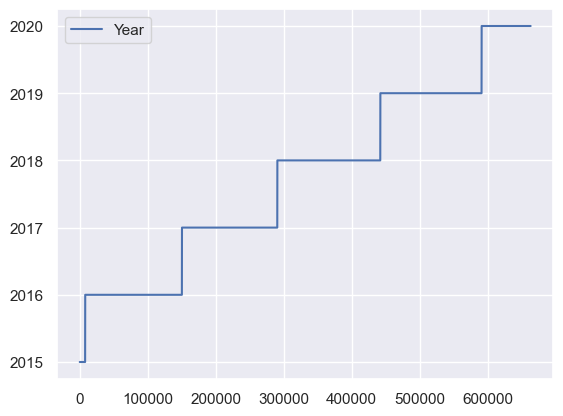

In [30]:
df.groupby(['Year','Month']).sum().sort_values(by='Year',ascending = False).head(8)

df[['Year']].plot()

                                                              

In [31]:
df_by_year= df.groupby('Year')
df_by_year.first()

 

,lat,lng,desc,zip,title,timeStamp,twp,addr,Department,Reason,Hour,Day,nDay_of_Week,Day_of_Week,Month
Year,,,,,,,,,,,,,,,
2015,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,EMS,BACK PAINS/INJURY,17,10,3,Thu,12
2016,40.121354,-75.363829,ROSEMONT AVE & W WASHINGTON ST; NORRISTOWN; S...,19401,EMS: ASSAULT VICTIM,2016-01-01 00:10:08,NORRISTOWN,ROSEMONT AVE & W WASHINGTON ST,EMS,ASSAULT VICTIM,0,1,4,Fri,1
2017,40.059554,-75.095024,OLD SOLDIERS RD & ASHBOURNE RD; CHELTENHAM; 20...,19027,Traffic: DISABLED VEHICLE -,2017-01-01 00:05:53,CHELTENHAM,OLD SOLDIERS RD & ASHBOURNE RD,Traffic,DISABLED VEHICLE -,0,1,6,Sun,1
2018,40.121736,-75.359385,HAMILTON ST & W MAIN ST; NORRISTOWN; Station ...,19401,EMS: FALL VICTIM,2018-01-01 00:08:58,NORRISTOWN,HAMILTON ST & W MAIN ST,EMS,FALL VICTIM,0,1,0,Mon,1
2019,40.250484,-75.407290,CHAMPIONSHIP DR & CLUBHOUSE DR; LOWER SALFORD...,19438,EMS: OVERDOSE,2019-01-01 00:02:30,LOWER SALFORD,CHAMPIONSHIP DR & CLUBHOUSE DR,EMS,OVERDOSE,0,1,1,Tue,1
2020,40.122337,-75.135601,BRADFIELD RD & SUSQUEHANNA RD; ABINGTON; 2020-...,19027,Fire: FIRE ALARM,2020-01-01 00:04:06,ABINGTON,BRADFIELD RD & SUSQUEHANNA RD,Fire,FIRE ALARM,0,1,2,Wed,1


## Are there differences in incident distributions based on different townships?

## 

In [53]:

department_list= df.Department.unique()
incident_df= pd.DataFrame()
most_ferq_twp=[]
for i in department_list:
    s= df[df['Department'] == i ]
    twp= s['twp'].value_counts().idxmax()
    most_ferq_twp.append(twp)

incident_df['Department']=department_list
incident_df['twp'] = most_ferq_twp

 
incident_df

,Department,twp
0,EMS,NORRISTOWN
1,Fire,LOWER MERION
2,Traffic,LOWER MERION


## the relation between the time and reason for emergency

In [58]:

time= df.Hour.unique()
# incident_df= pd.DataFrame()
# most_ferq_twp=[]
# for i in department_list:
#     s= df[df['Department'] == i ]
#     twp= s['twp'].value_counts().idxmax()
#     most_ferq_twp.append(twp)

# incident_df['Department']=department_list
# incident_df['twp'] = most_ferq_twp
s= df.sample(frac=0.25)
corr=df['Hour'].corr(df['Reason'])
corr


 


## How do the incidents vary over different hours, days, and months

In [39]:

most_incidents_in_most_hour= df[df['Hour'] ==df['Hour'].value_counts().idxmax()]
print(most_incidents_in_most_hour['Department'].value_counts().idxmax())

most_incidents_in_most_day= df[df['Day'] ==df['Day'].value_counts().idxmax()]
print(most_incidents_in_most_day['Department'].value_counts().idxmax())


most_incidents_in_most_month= df[df['Month'] ==df['Month'].value_counts().idxmax()]
print(most_incidents_in_most_month['Department'].value_counts().idxmax())



Traffic
EMS
EMS


## How do incidents vary during different months

In [41]:

monthes_list= df.Month.unique()
df_1= pd.DataFrame()
most_ferq_department=[]
for i in monthes_list:
    s= df[df['Month'] == i ]
    department= s['Department'].value_counts().idxmax()
    most_ferq_department.append(department)

df_1['Month']=monthes_list
df_1['Department'] = most_ferq_department

 
df_1

,Month,Department
0,12,EMS
1,1,EMS
2,2,EMS
3,3,EMS
4,4,EMS
5,5,EMS
6,6,EMS
7,7,EMS
8,8,EMS
9,9,EMS


## Are there specific patterns in incidents based on the day of the week

In [46]:
Day_list= df.Day.unique()
df_2= pd.DataFrame()
most_ferq_incidents=[]
for i in Day_list:
    s= df[df['Day'] == i ]
    department= s['Department'].value_counts().idxmax()
    if(department):
        most_ferq_incidents.append(department)
    else:
        most_ferq_incidents.append(NULL)
        
# print (most_ferq_incidents, )

df_2['Day']=Day_list
df_2['Department'] = most_ferq_incidents

df_2

,Day,Department
0,10,EMS
1,11,EMS
2,12,EMS
3,13,EMS
4,14,EMS
5,15,EMS
6,16,EMS
7,17,EMS
8,18,EMS
9,19,EMS


## Does place affect the type of emergencies


In [48]:

add_list= df.addr.unique()
df_3= pd.DataFrame()
most_ferq_emergencie=[]
for i in add_list:
    s= df[df['addr'] == i ]
    twp= s['Department'].value_counts().idxmax()
    most_ferq_emergencir.append(twp)

df_3['addr']=add_list
df_3['Department'] = most_ferq_emergencie

 
df_3

KeyboardInterrupt: 

## What are the top 5 zip codes for 911 calls

In [ ]:
df.nlargest(5, 'zip')


## Average number of times during one month

In [50]:
# N = 1000
# times = pd.date_range('2014', '2015', freq='min')
# ind = np.random.permutation(np.arange(len(times)))[:N]

# data = pd.DataFrame({'TIMESTAMP': times[ind],
#                      'TYPE': np.random.randint(0, 10, N)})
# data.head()

df.groupby(pd.PeriodIndex(df['timeStamp'], freq="M"))['Hour'].mean()


timeStamp
2015-12    13.390127
2016-01    12.945845
2016-02    13.075384
2016-03    13.014212
2016-04    12.904369
2016-05    13.071580
2016-06    13.216345
2016-07    13.228281
2016-08    13.017982
2016-09    12.972484
2016-10    13.164733
2016-11    13.098792
2016-12    13.008638
2017-01    12.789533
2017-02    12.821105
2017-03    12.761130
2017-04    13.129672
2017-05    13.088735
2017-06    13.365420
2017-07    13.191788
2017-08    13.024270
2017-09    12.967200
2017-10    12.919747
2017-11    13.003119
2017-12    13.113241
2018-01    12.741997
2018-02    13.045259
2018-03    13.326451
2018-04    13.088442
2018-05    13.002870
2018-06    12.993137
2018-07    13.066427
2018-08    12.956539
2018-09    13.030738
2018-10    12.964388
2018-11    13.158537
2018-12    12.928742
2019-01    12.823300
2019-02    12.888418
2019-03    12.906677
2019-04    12.979117
2019-05    13.269066
2019-06    13.132109
2019-07    13.358446
2019-08    13.145512
2019-09    12.988880
2019-10    13.124152
201

## What is the most common Reason for a 911 call based off of this new column

In [53]:
df.sort_values(by=['Reason'])['Reason'].value_counts().idxmax()


' VEHICLE ACCIDENT -'

-------
--------

<details>
  <summary><strong>Done By</strong></summary>
  <p align="center">Ahmed NasrElDin and Gehad Samir</p>
</details>

-------
--------